In [10]:
import slideio
from utils import get_test_images, display_driver_test_image_info, show_images, show_image, get_driver_test_images, show_scene_info, show_scenes
from IPython.display import display
import json
import pandas as pd
import random

# Test images
For the future demonstration of the library, we will be utilizing some test images. Information regarding the images and the drivers required for image processing is stored in the *image.json* file. The helper utility *get_test_images* loads this image information into a list for convenient access and utilization during the demonstration.

In [2]:
images = get_driver_test_images('DCM')
display_driver_test_image_info(images, 'DCM', True)

Image Path,Driver,Options
./images/MR-MONO2-8-16x-heart,DCM,Z-STACK
./images/BPAEC,DCM,WSI
./images/FluorCell_4,DCM,WSI
./images/FluorCell_4/3_0,DCM,WSI-SINGLE
./images/GSPS_Liver/DICOMDIR,DCM,DICOMDIR


In [3]:
zstack_images = [image for image in images if image['options']=='Z-STACK'] 
slide = slideio.open_slide(zstack_images[0]['path'],"DCM")
f"Number of scenes: {slide.num_scenes}"

'Number of scenes: 1'

In [4]:
scene = slide.get_scene(0)
show_scene_info(scene)

Property,Value
Name,999.999.2.19960619.163000.1
File Path,./images/MR-MONO2-8-16x-heart
"Size (Width, Height)","(256, 256)"
Number of Channels,1
Compression,Compression.Uncompressed
Data Type,uint8
Magnification,0.0
Resolution,"(0.0, 0.0)"
Z-Resolution,0.0
Time Resolution,0.0


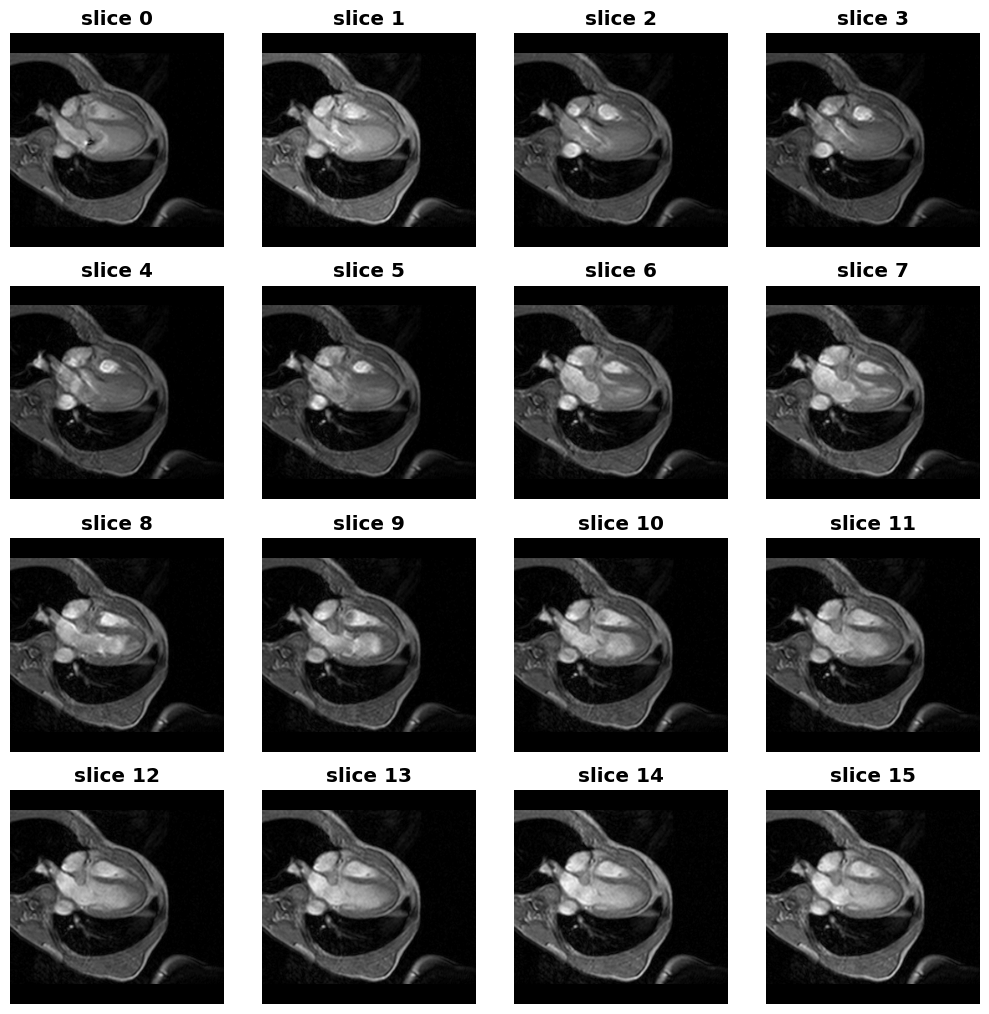

In [5]:
slices = []
titles = []
for z in range(scene.num_z_slices):
    slice = scene.read_block(slices=(z,z+1))
    slices.append(slice)
    titles.append(f"slice {z}")
show_images(slices, titles, 256)

# WSI Images

In [6]:
wsi_images = [image for image in images if image['options']=='WSI']
wsi_scenes = []
for im in wsi_images:
    slide = slideio.open_slide(im['path'],"DCM")
    scene = slide.get_scene(0)
    wsi_scenes.append(scene)
    show_scene_info(scene)

Property,Value
Name,2.25.65969465079325811891707675551046647345
File Path,./images/BPAEC
"Size (Width, Height)","(12288, 9216)"
Number of Channels,1
Compression,Compression.Jpeg
Data Type,uint8
Magnification,0.0
Resolution,"(0.0, 0.0)"
Z-Resolution,0.0
Time Resolution,0.0


Property,Value
Name,2.25.83282858720704132758110891374375550907
File Path,./images/FluorCell_4
"Size (Width, Height)","(11264, 11264)"
Number of Channels,1
Compression,Compression.Jpeg
Data Type,uint8
Magnification,0.0
Resolution,"(0.0, 0.0)"
Z-Resolution,0.0
Time Resolution,0.0


Number of scenes: 2


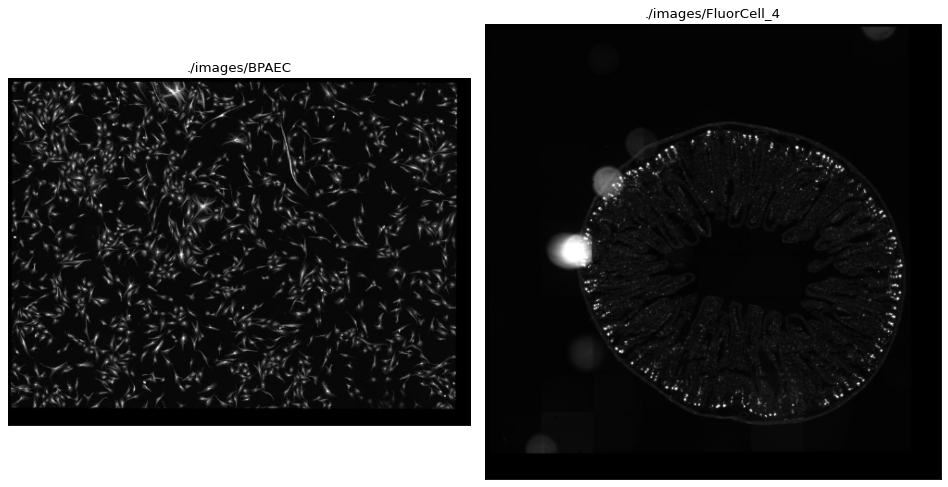

In [7]:
show_scenes(wsi_scenes, 2, (500,500))

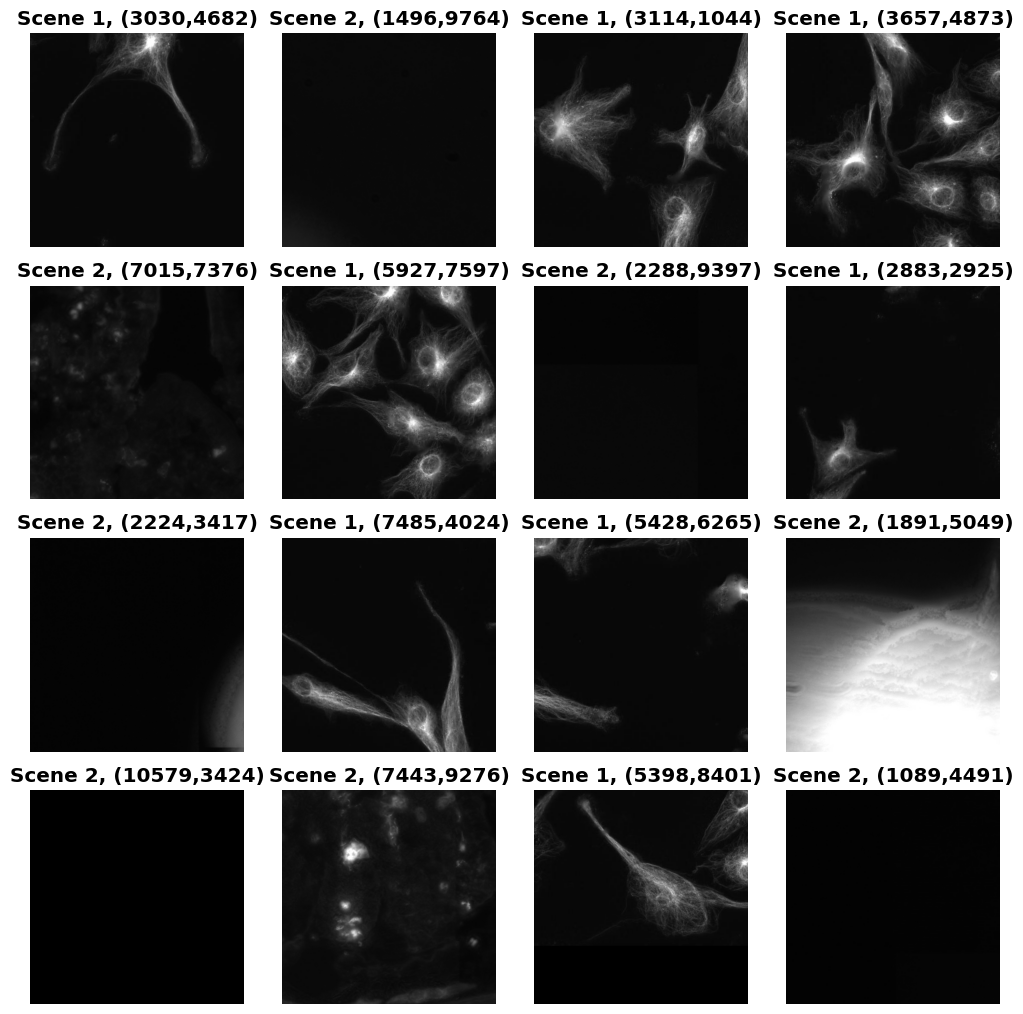

In [18]:
tile_size = (500,500)
num_scenes = len(wsi_scenes)
tiles = []
titles = []
for tile in range (16):
    scene_index = random.randint(0,num_scenes-1)
    scene = wsi_scenes[scene_index]
    scene_size = scene.size
    x = random.randint(0, scene_size[0]-tile_size[0]-1)
    y = random.randint(0, scene_size[1]-tile_size[1]-1)
    rect = (x, y, tile_size[0],tile_size[1])
    tile_img = scene.read_block(rect)
    tiles.append(tile_img)
    titles.append(f"Scene {scene_index+1}, ({x},{y})")
show_images(tiles,titles,256)

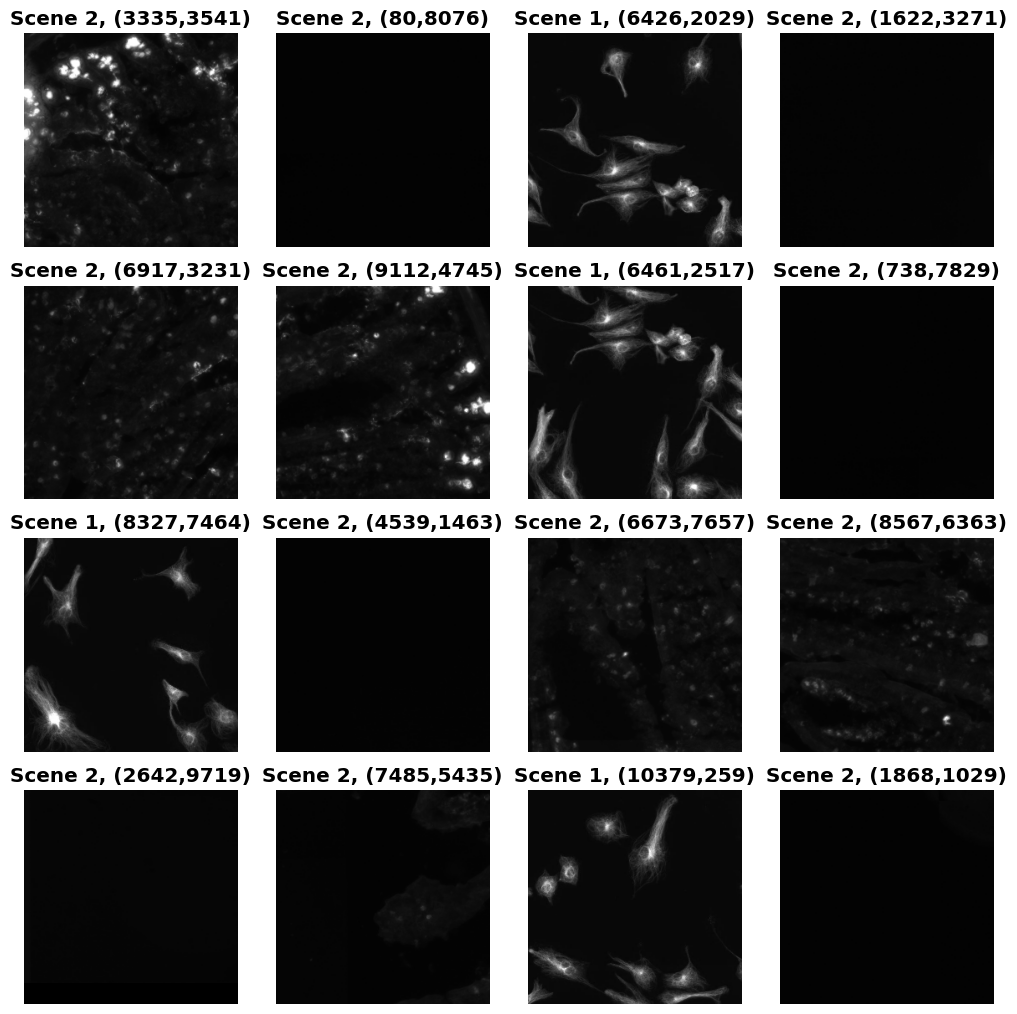

In [19]:
tile_size = (1000,1000)
scale_to = (256, 256)
num_scenes = len(wsi_scenes)
tiles = []
titles = []
for tile in range (16):
    scene_index = random.randint(0,num_scenes-1)
    scene = wsi_scenes[scene_index]
    scene_size = scene.size
    x = random.randint(0, scene_size[0]-tile_size[0]-1)
    y = random.randint(0, scene_size[1]-tile_size[1]-1)
    rect = (x, y, tile_size[0],tile_size[1])
    tile_img = scene.read_block(rect, size=scale_to)
    tiles.append(tile_img)
    titles.append(f"Scene {scene_index+1}, ({x},{y})")
show_images(tiles,titles,256)